In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix
import xgboost as xgb
import numpy as np

from keras.preprocessing.image import load_img, img_to_array

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import time

In [3]:
data = pd.DataFrame(columns=['image_path', 'label'])

#define the labels&classes
labels = {
    'satellite/satellite/data/cloudy': 'Cloudy',
    'satellite/satellite/data/desert': 'Desert',
    'satellite/satellite/data/green_area': 'Green_Area',
    'satellite/satellite/data/water': 'Water',
}

In [4]:
data_list = []
#loop through each label directory and add file paths and labels to the list
for path, label in labels.items():
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)
                data_list.append({'image_path': file_path, 'label': label})

#converting the list to a dataframe
data = pd.DataFrame(data_list)
print(data.head())

                              image_path   label
0  satellite/data/cloudy\train_10021.jpg  Cloudy
1  satellite/data/cloudy\train_10043.jpg  Cloudy
2  satellite/data/cloudy\train_10070.jpg  Cloudy
3  satellite/data/cloudy\train_10081.jpg  Cloudy
4  satellite/data/cloudy\train_10096.jpg  Cloudy


In [5]:
data.head()

,image_path,label
0,satellite/data/cloudy\train_10021.jpg,Cloudy
1,satellite/data/cloudy\train_10043.jpg,Cloudy
2,satellite/data/cloudy\train_10070.jpg,Cloudy
3,satellite/data/cloudy\train_10081.jpg,Cloudy
4,satellite/data/cloudy\train_10096.jpg,Cloudy


In [6]:
data.tail()

,image_path,label
5626,satellite/data/water\SeaLake_995.jpg,Water
5627,satellite/data/water\SeaLake_996.jpg,Water
5628,satellite/data/water\SeaLake_997.jpg,Water
5629,satellite/data/water\SeaLake_998.jpg,Water
5630,satellite/data/water\SeaLake_999.jpg,Water


In [7]:
data.shape

(5631, 2)

In [8]:
def load_and_preprocess_image(image_path, image_size=(28, 28)):
    image = load_img(image_path, target_size=image_size) # load and resize image
    image = img_to_array(image) # convert image to numpy array
    image = image / 255.0
    return image

In [9]:
X = []
y = []

for index, row in data.iterrows():
    image_path = row['image_path']
    label = row['label']
    try:
        image = load_and_preprocess_image(image_path)
        X.append(image)
        y.append(label)
    except Exception as e:
        print(f"Error processing image: {image_path}, Error: {e}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (5631, 28, 28, 3)
y shape: (5631,)


Classes found by label encoder: ['Cloudy' 'Desert' 'Green_Area' 'Water']
X_train shape: (4504, 28, 28, 3), X_val shape: (1127, 28, 28, 3), y_train shape: (4504, 4), y_val shape: (1127, 4)


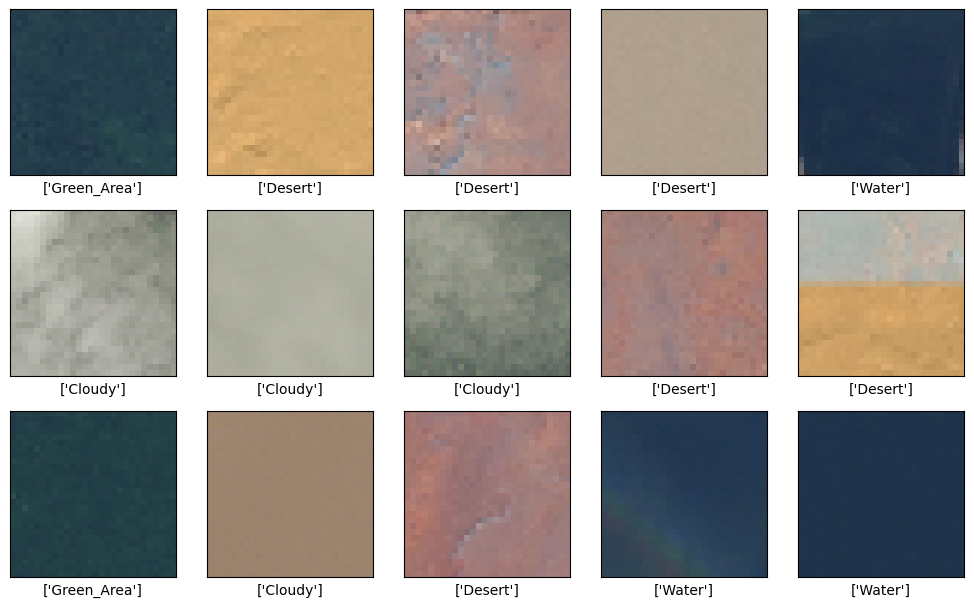

In [10]:
if y.size > 0:
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print("Classes found by label encoder:", label_encoder.classes_)
    
    # One-hot encoding of labels
    y_one_hot = to_categorical(y_encoded)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
    
    print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")
    
    # Visualize some images from X_train
    plt.figure(figsize=(10, 10))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train[i], cmap=plt.cm.binary)
        plt.xlabel(label_encoder.inverse_transform([np.argmax(y_train[i])])) # Show the label
    plt.tight_layout()
    plt.show()

else:
    print("Error: y is empty")

Defining and Training the Models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4504, 28, 28, 3) (1127, 28, 28, 3) (4504, 4) (1127, 4)


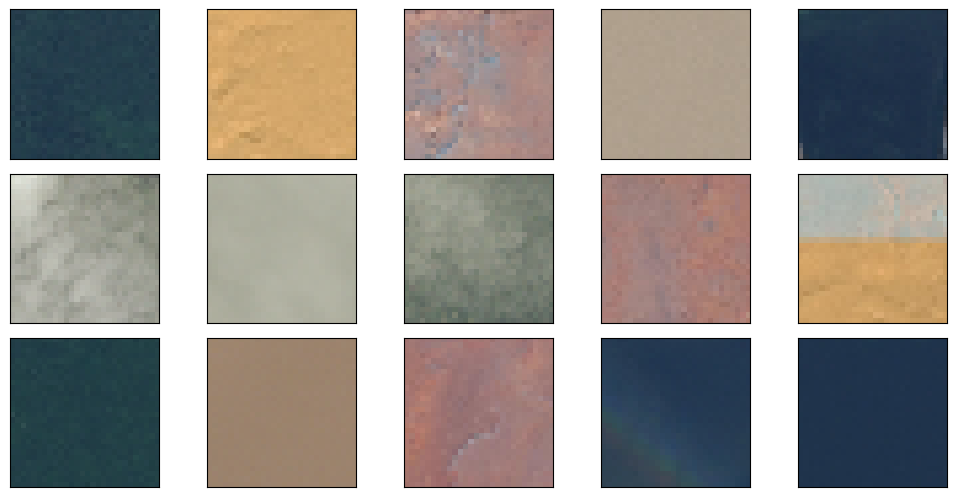

In [12]:
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.tight_layout()
plt.show()


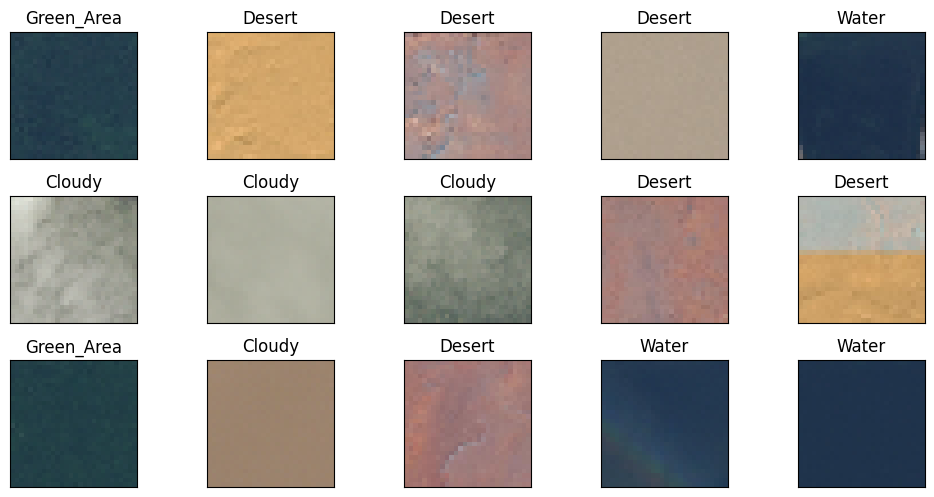

In [13]:
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    
    # We can find which class each image belongs to using y_train
    class_index = y_train[i].argmax()
    class_name = label_encoder.classes_[class_index]
    plt.title(class_name)
    
plt.tight_layout()
plt.show()


Class: Cloudy, Total images: 3


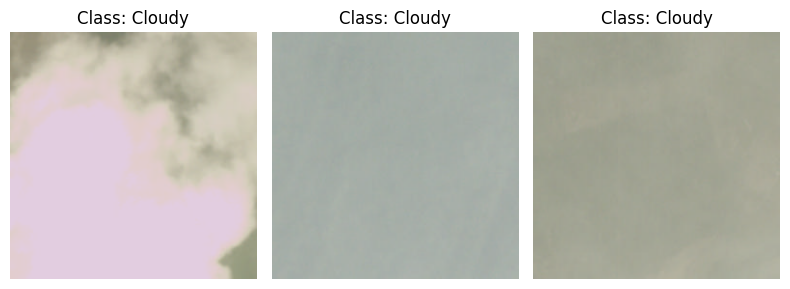

Class: Desert, Total images: 3


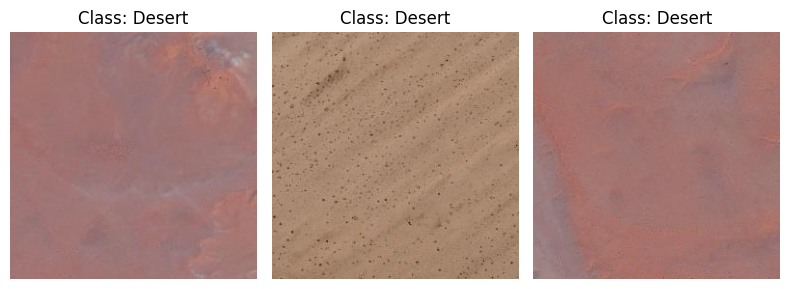

Class: Green_Area, Total images: 3


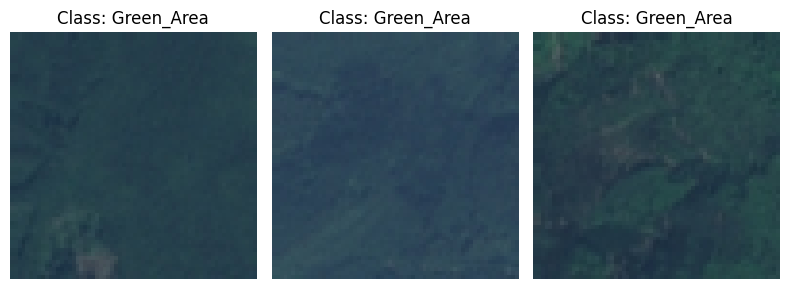

Class: Water, Total images: 3


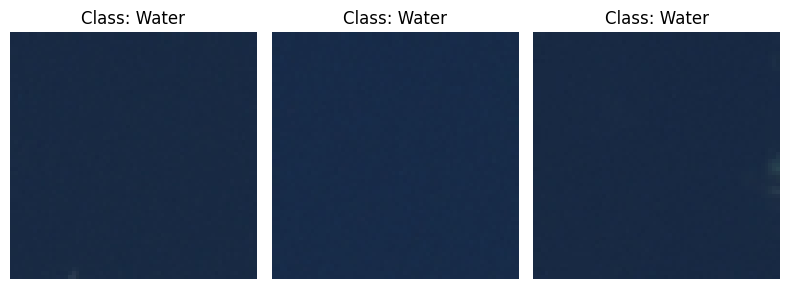

In [14]:
def show_first_images_from_each_class(data, labels, num_images=3):
    classes = pd.unique(labels)
    
    for cls in classes:
        class_data = data[data['label'] == cls].head(num_images)
        num_samples = len(class_data)
        print(f"Class: {cls}, Total images: {num_samples}")
        
        plt.figure(figsize=(8, 4))
        
        for i in range(num_samples):
            image_path = class_data.iloc[i]['image_path']
            image = plt.imread(image_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(image)
            plt.title(f"Class: {cls}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
#Example usage:
show_first_images_from_each_class(data, data['label'], num_images=3)

In [15]:
def plot_confusion_matrix(cm, title):
    num_classes = cm.shape[0]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(title)
    plt.show()

In [16]:
def train_knn(X_train, y_train, X_test, y_test):
    # Train the K-NN model with training data
    knn_model = KNeighborsClassifier()
    start = time.time()
    knn_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"KNN Training Time        : {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = knn_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("KNN Accuracy             :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                :", precision)
    print("Recall                   :", recall)
    print("F1 Score                 :", f1)
    print("KNN Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'KNN Confusion Matrix')

In [17]:
def train_random_forest(X_train, y_train, X_test, y_test):
    # Train the Random Forest model with training data
    rf_model = RandomForestClassifier(random_state=42)
    start = time.time()
    rf_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"Random Forest Training Time: {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = rf_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("Random Forest Accuracy   :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                :", precision)
    print("Recall                   :", recall)
    print("F1 Score                 :", f1)
    print("Random Forest Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'Random Forest Confusion Matrix')

In [18]:
def train_decision_tree(X_train, y_train, X_test, y_test):
    # Train the Decision Tree model with training data
    dt_model = DecisionTreeClassifier(random_state=42)
    start = time.time()
    dt_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"Decision Tree Training Time: {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = dt_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("Decision Tree Accuracy   :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                :", precision)
    print("Recall                   :", recall)
    print("F1 Score                 :", f1)
    print("Decision Tree Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'Decision Tree Confusion Matrix')

In [19]:
def train_svm(X_train, y_train, X_test, y_test):
    # Train the SVM model with training data
    svm_model = SVC(random_state=42)
    start = time.time()
    svm_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"SVM Training Time        : {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = svm_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("SVM Accuracy             :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                :", precision)
    print("Recall                   :", recall)
    print("F1 Score                 :", f1)
    print("SVM Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'SVM Confusion Matrix')

In [20]:
def train_xgboost(X_train, y_train, X_test, y_test):
    # Train the XGBoost model with training data
    xgb_model = xgb.XGBClassifier(random_state=42)
    start = time.time()
    xgb_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"XGBoost Training Time    : {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = xgb_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("XGBoost Accuracy         :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                :", precision)
    print("Recall                   :", recall)
    print("F1 Score                 :", f1)
    print("XGBoost Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'XGBoost Confusion Matrix')

In [21]:
def train_gradient_boosting(X_train, y_train, X_test, y_test):
    # Train the Gradient Boosting model with training data
    gb_model = GradientBoostingClassifier(random_state=42)
    start = time.time()
    gb_model.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
    end = time.time()
    training_time = end - start
    print(f"Gradient Boosting Training Time: {training_time:.2f} seconds")
    
    # Make predictions on test data
    y_pred = gb_model.predict(X_test.reshape(len(X_test), -1))
    
    # Calculate performance metrics
    print("Gradient Boosting Accuracy   :", accuracy_score(y_test.argmax(axis=1), y_pred))
    precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test.argmax(axis=1), y_pred, average='weighted')
    f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
    
    print("Precision                    :", precision)
    print("Recall                       :", recall)
    print("F1 Score                     :", f1)
    print("Gradient Boosting Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    
    # Visualization
    plot_confusion_matrix(cm, 'Gradient Boosting Confusion Matrix')

0: Cloudy

1: Desert

2: Green_Area

3: Water

KNN Training Time        : 0.02 seconds
KNN Accuracy             : 0.8491570541259982
Precision                : 0.8878212667773462
Recall                   : 0.8491570541259982
F1 Score                 : 0.8431595624479544
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       328
           1       0.99      0.91      0.95       227
           2       0.97      0.52      0.68       284
           3       0.67      0.99      0.79       288

    accuracy                           0.85      1127
   macro avg       0.89      0.85      0.84      1127
weighted avg       0.89      0.85      0.84      1127



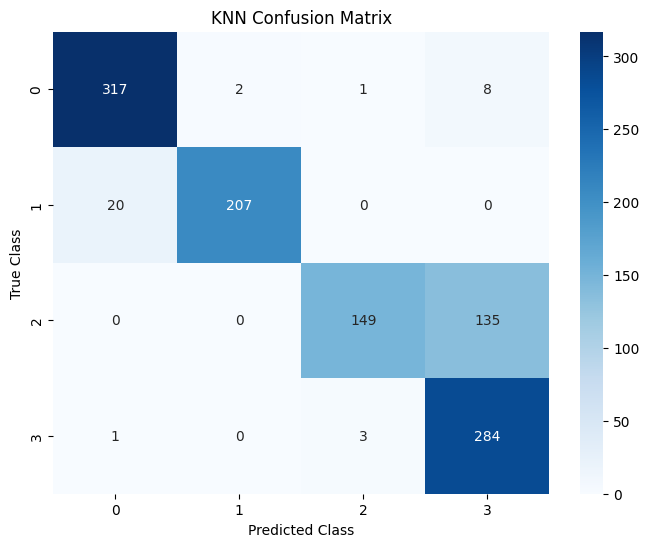

In [22]:
train_knn(X_train, y_train, X_test, y_test)

Random Forest Training Time: 7.41 seconds
Random Forest Accuracy   : 0.9467613132209406
Precision                : 0.9472909855466892
Recall                   : 0.9467613132209406
F1 Score                 : 0.9468580945047183
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       328
           1       0.99      0.95      0.97       227
           2       0.91      0.95      0.93       284
           3       0.93      0.92      0.92       288

    accuracy                           0.95      1127
   macro avg       0.95      0.95      0.95      1127
weighted avg       0.95      0.95      0.95      1127



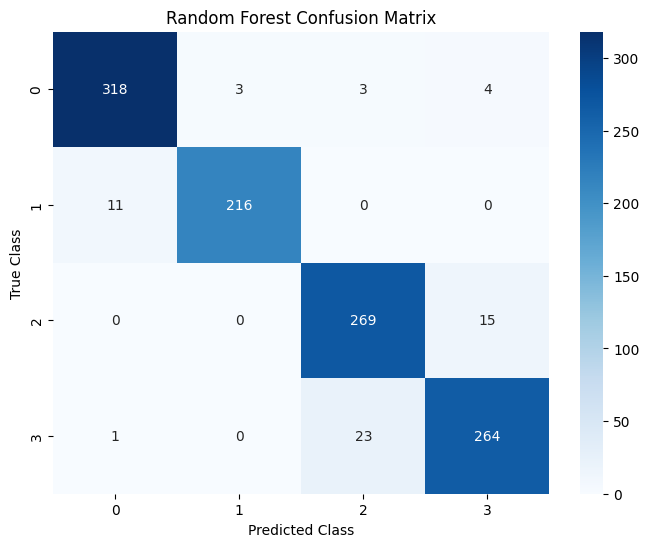

In [23]:
train_random_forest(X_train, y_train, X_test, y_test)

Decision Tree Training Time: 5.07 seconds
Decision Tree Accuracy   : 0.8740017746228926
Precision                : 0.8787079734693062
Recall                   : 0.8740017746228926
F1 Score                 : 0.8745026311309196
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       328
           1       0.90      0.94      0.92       227
           2       0.88      0.81      0.84       284
           3       0.78      0.89      0.83       288

    accuracy                           0.87      1127
   macro avg       0.88      0.88      0.88      1127
weighted avg       0.88      0.87      0.87      1127



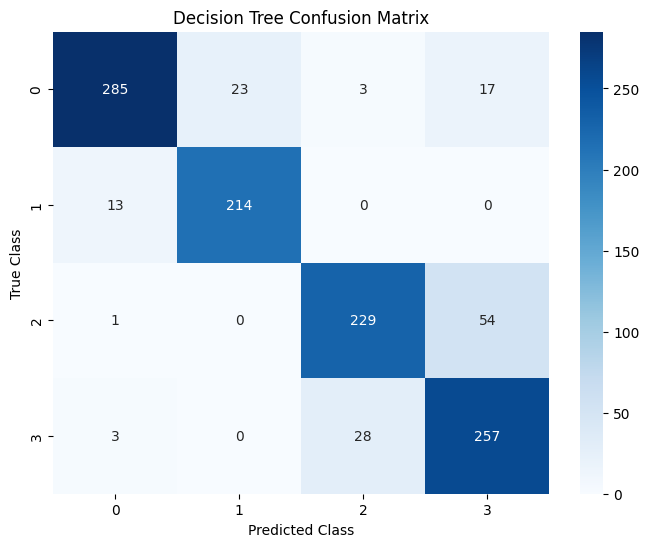

In [24]:
train_decision_tree(X_train, y_train, X_test, y_test)

SVM Training Time        : 4.66 seconds
SVM Accuracy             : 0.906832298136646
Precision                : 0.9104717329338774
Recall                   : 0.906832298136646
F1 Score                 : 0.9067558087628449
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       328
           1       0.93      0.96      0.94       227
           2       0.82      0.94      0.88       284
           3       0.92      0.81      0.86       288

    accuracy                           0.91      1127
   macro avg       0.91      0.91      0.91      1127
weighted avg       0.91      0.91      0.91      1127



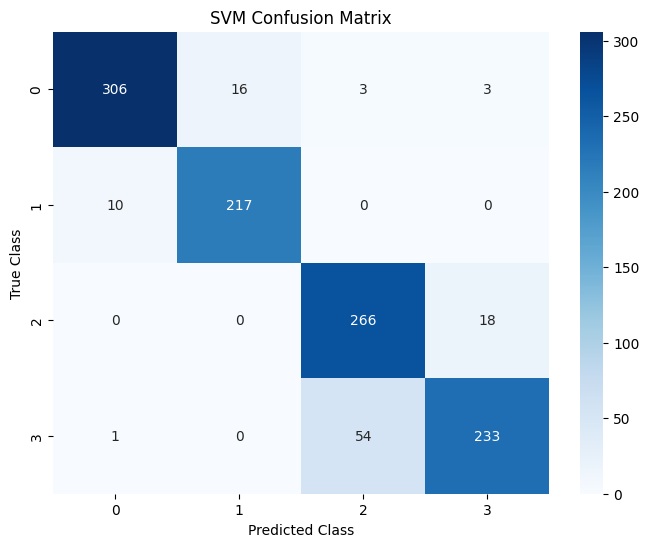

In [25]:
train_svm(X_train, y_train, X_test, y_test)

XGBoost Training Time    : 47.39 seconds
XGBoost Accuracy         : 0.9503105590062112
Precision                : 0.9506097705094899
Recall                   : 0.9503105590062112
F1 Score                 : 0.9504203716656014
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       328
           1       0.98      0.96      0.97       227
           2       0.93      0.94      0.93       284
           3       0.92      0.94      0.93       288

    accuracy                           0.95      1127
   macro avg       0.95      0.95      0.95      1127
weighted avg       0.95      0.95      0.95      1127



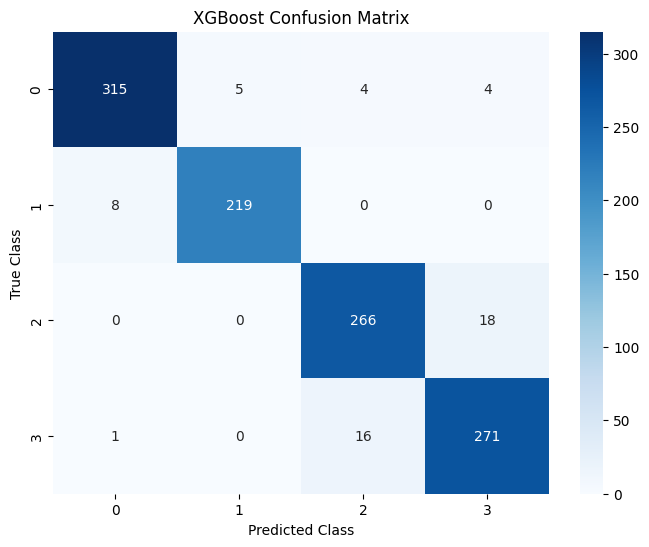

In [26]:
train_xgboost(X_train, y_train, X_test, y_test)

Gradient Boosting Training Time: 615.08 seconds
Gradient Boosting Accuracy   : 0.9334516415261757
Precision                    : 0.9342778857875612
Recall                       : 0.9334516415261757
F1 Score                     : 0.9336692469452829
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       328
           1       0.97      0.94      0.96       227
           2       0.92      0.91      0.92       284
           3       0.89      0.93      0.91       288

    accuracy                           0.93      1127
   macro avg       0.94      0.93      0.93      1127
weighted avg       0.93      0.93      0.93      1127



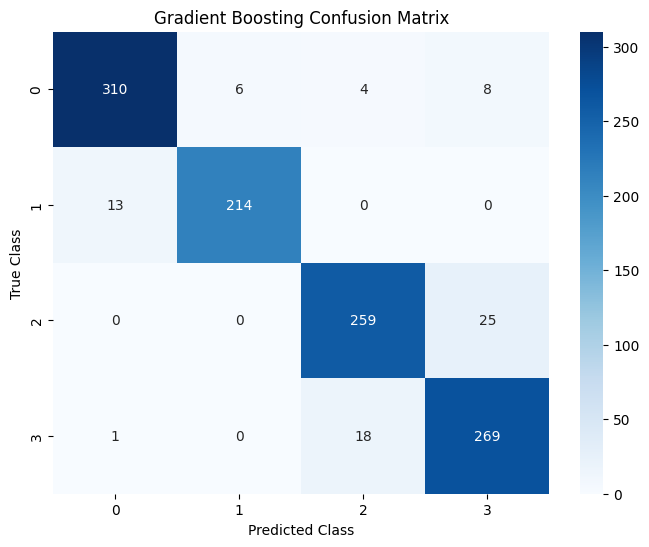

In [27]:
train_gradient_boosting(X_train, y_train, X_test, y_test)